In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import os
import sys

In [2]:
def toTapleList(list1,list2):
    return list(itertools.product(list1,list2))

In [3]:


# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train = pd.read_csv('../input/train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('../input/test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)


In [5]:
null_cnt = train.isnull().sum().sort_values()
print('null count:', null_cnt[null_cnt > 0])
# dropna
train.dropna(inplace=True)

null count: winPlacePerc    1
dtype: int64


In [6]:
train.describe(include=np.number).drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.233815,0.588573,0.0,0.000000,0.000000,0.0000,22.0
boosts,1.106908,1.715794,0.0,0.000000,0.000000,2.0000,33.0
damageDealt,130.633148,169.886963,0.0,0.000000,84.239998,186.0000,6616.0
DBNOs,0.657876,1.145743,0.0,0.000000,0.000000,1.0000,53.0
headshotKills,0.226820,0.602155,0.0,0.000000,0.000000,0.0000,64.0
heals,1.370148,2.679982,0.0,0.000000,0.000000,2.0000,80.0
killPlace,47.599361,27.462931,1.0,24.000000,47.000000,71.0000,101.0
killPoints,505.006156,627.504921,0.0,0.000000,0.000000,1172.0000,2170.0
kills,0.924784,1.558445,0.0,0.000000,0.000000,1.0000,72.0
killStreaks,0.543955,0.710972,0.0,0.000000,0.000000,1.0000,20.0


**Data Analysis**

**Id, GroupId, MatchId**

In [8]:
for c in ['Id','groupId','matchId']:
    print(f'unique [{c}] count:', train[c].nunique())

unique [Id] count: 4446965
unique [groupId] count: 2026744
unique [matchId] count: 47964


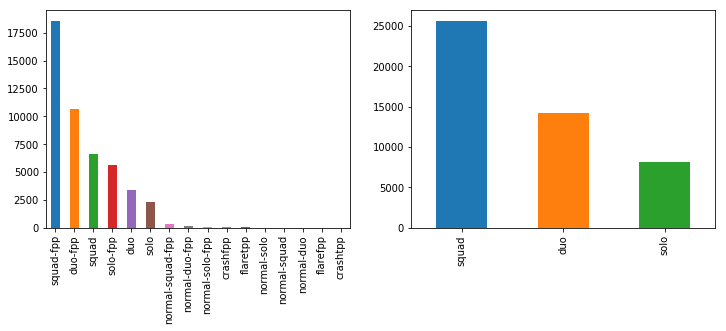

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

'''
solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp
duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp
squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp
'''
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

In [10]:
all_data = train.append(test, sort=False).reset_index(drop=True)
del train, test
gc.collect()

44

In [11]:
match = all_data.groupby('matchId')
all_data['killsPerc'] = match['kills'].rank(pct=True).values
all_data['killPlacePerc'] = match['killPlace'].rank(pct=True).values
all_data['walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
#all_data['damageDealtPerc'] = match['damageDealt'].rank(pct=True).values
all_data['walkPerc_killsPerc'] = all_data['walkDistancePerc'] / all_data['killsPerc']

In [12]:
all_data['_totalDistance'] = all_data['rideDistance'] + all_data['walkDistance'] + all_data['swimDistance']

In [13]:
def fillInf(df, val):
    numcols = df.select_dtypes(include='number').columns
    cols = numcols[numcols != 'winPlacePerc']
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    for c in cols: df[c].fillna(val, inplace=True)

In [14]:
all_data['_healthItems'] = all_data['heals'] + all_data['boosts']
all_data['_headshotKillRate'] = all_data['headshotKills'] / all_data['kills']
all_data['_killPlaceOverMaxPlace'] = all_data['killPlace'] / all_data['maxPlace']
all_data['_killsOverWalkDistance'] = all_data['kills'] / all_data['walkDistance']

fillInf(all_data, 0)

In [22]:
match = all_data.groupby(['matchId'])
group = all_data.groupby(['matchId','groupId','matchType'])

# target feature (max, min)
agg_col = list(all_data.columns)
exclude_agg_col = ['Id','matchId','groupId','matchType','maxPlace','numGroups','winPlacePerc']
for c in exclude_agg_col:
    agg_col.remove(c)
print(agg_col)

# target feature (sum)
sum_col = ['kills','killPlace','damageDealt','walkDistance','_healthItems']

['assists', 'damageDealt', 'killPlace', 'kills', 'longestKill', 'revives', 'teamKills', 'walkDistance', 'weaponsAcquired', 'killsPerc', 'killPlacePerc', 'walkDistancePerc', 'walkPerc_killsPerc', '_totalDistance', '_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance']


In [23]:
match_data = pd.concat([
    match.size().to_frame('m.players'), 
    match[sum_col].sum().rename(columns=lambda s: 'm.sum.' + s), 
    match[sum_col].max().rename(columns=lambda s: 'm.max.' + s),
    match[sum_col].mean().rename(columns=lambda s: 'm.mean.' + s)
    ], axis=1).reset_index()
match_data = pd.merge(match_data, 
    group[sum_col].sum().rename(columns=lambda s: 'sum.' + s).reset_index())
match_data = reduce_mem_usage(match_data)

print(match_data.shape)

Memory usage of dataframe is 408.37 MB --> 288.92 MB (Decreased by 29.3%)
(2912982, 24)


In [25]:
minKills = all_data.sort_values(['matchId','groupId','kills','killPlace']).groupby(
    ['matchId','groupId','kills']).first().reset_index().copy()
for n in np.arange(4):
    c = 'kills_' + str(n) + '_Place'
    nKills = (minKills['kills'] == n)
    minKills.loc[nKills, c] = minKills[nKills].groupby(['matchId'])['killPlace'].rank().values
    match_data = pd.merge(match_data, minKills[nKills][['matchId','groupId',c]], how='left')
    #match_data[c].fillna(0, inplace=True)
match_data = reduce_mem_usage(match_data)
del minKills, nKills

print(match_data.shape)

Memory usage of dataframe is 333.36 MB --> 333.36 MB (Decreased by 0.0%)
(2912982, 28)


In [26]:
all_data = pd.concat([
    group.size().to_frame('players'),
    group.mean(),
    group[agg_col].max().rename(columns=lambda s: 'max.' + s),
    group[agg_col].min().rename(columns=lambda s: 'min.' + s),
    ], axis=1).reset_index()
all_data = reduce_mem_usage(all_data)

print(all_data.shape)

Memory usage of dataframe is 911.20 MB --> 591.72 MB (Decreased by 35.1%)
(2912982, 61)


In [27]:
numcols = all_data.select_dtypes(include='number').columns.values
numcols = numcols[numcols != 'winPlacePerc']

In [28]:
all_data = pd.merge(all_data, match_data)
del match_data
gc.collect()

all_data['enemy.players'] = all_data['m.players'] - all_data['players']
for c in sum_col:
    #all_data['enemy.' + c] = (all_data['m.sum.' + c] - all_data['sum.' + c]) / all_data['enemy.players']
    #all_data['p.sum_msum.' + c] = all_data['sum.' + c] / all_data['m.sum.' + c]
    #all_data['p.max_mmean.' + c] = all_data['max.' + c] / all_data['m.mean.' + c]
    all_data['p.max_msum.' + c] = all_data['max.' + c] / all_data['m.sum.' + c]
    all_data['p.max_mmax.' + c] = all_data['max.' + c] / all_data['m.max.' + c]
    all_data.drop(['m.sum.' + c, 'm.max.' + c], axis=1, inplace=True)
    
fillInf(all_data, 0)
print(all_data.shape)

(2912982, 87)


In [29]:
match = all_data.groupby('matchId')
matchRank = match[numcols].rank(pct=True).rename(columns=lambda s: 'rank.' + s)
all_data = reduce_mem_usage(pd.concat([all_data, matchRank], axis=1))
rank_col = matchRank.columns
del matchRank
gc.collect()

# instead of rank(pct=True, method='dense')
match = all_data.groupby('matchId')
matchRank = match[rank_col].max().rename(columns=lambda s: 'max.' + s).reset_index()
all_data = pd.merge(all_data, matchRank)
for c in numcols:
    all_data['rank.' + c] = all_data['rank.' + c] / all_data['max.rank.' + c]
    all_data.drop(['max.rank.' + c], axis=1, inplace=True)
del matchRank
gc.collect()

print(all_data.shape)

Memory usage of dataframe is 2186.31 MB --> 1519.59 MB (Decreased by 30.5%)
(2912982, 144)


In [30]:
killMinorRank = all_data[['matchId','min.kills','max.killPlace']].copy()
group = killMinorRank.groupby(['matchId','min.kills'])
killMinorRank['rank.minor.maxKillPlace'] = group.rank(pct=True).values
all_data = pd.merge(all_data, killMinorRank)

killMinorRank = all_data[['matchId','max.kills','min.killPlace']].copy()
group = killMinorRank.groupby(['matchId','max.kills'])
killMinorRank['rank.minor.minKillPlace'] = group.rank(pct=True).values
all_data = pd.merge(all_data, killMinorRank)

del killMinorRank
gc.collect()

63

In [31]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: ['rank.maxPlace', 'rank.numGroups']


In [32]:
all_data['matchType'] = all_data['matchType'].apply(mapper)

all_data = pd.concat([all_data, pd.get_dummies(all_data['matchType'])], axis=1)
all_data.drop(['matchType'], axis=1, inplace=True)

all_data['matchId'] = all_data['matchId'].apply(lambda x: int(x,16))
all_data['groupId'] = all_data['groupId'].apply(lambda x: int(x,16))

In [33]:
null_cnt = all_data.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

winPlacePerc    886238
dtype: int64


In [34]:
#all_data.drop([],axis=1,inplace=True)

cols = [col for col in all_data.columns if col not in ['Id','matchId','groupId']]
for i, t in all_data.loc[:, cols].dtypes.iteritems():
    if t == object:
        all_data[i] = pd.factorize(all_data[i])[0]

all_data = reduce_mem_usage(all_data)
all_data.head()

Memory usage of dataframe is 1527.92 MB --> 1530.70 MB (Decreased by -0.2%)


,matchId,groupId,players,assists,damageDealt,killPlace,kills,longestKill,maxPlace,numGroups,revives,teamKills,walkDistance,weaponsAcquired,winPlacePerc,killsPerc,killPlacePerc,walkDistancePerc,walkPerc_killsPerc,_totalDistance,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,max.assists,max.damageDealt,max.killPlace,max.kills,max.longestKill,max.revives,max.teamKills,max.walkDistance,max.weaponsAcquired,max.killsPerc,max.killPlacePerc,max.walkDistancePerc,max.walkPerc_killsPerc,max._totalDistance,max._healthItems,max._headshotKillRate,...,rank.max.damageDealt,rank.max.killPlace,rank.max.kills,rank.max.longestKill,rank.max.revives,rank.max.teamKills,rank.max.walkDistance,rank.max.weaponsAcquired,rank.max.killsPerc,rank.max.killPlacePerc,rank.max.walkDistancePerc,rank.max.walkPerc_killsPerc,rank.max._totalDistance,rank.max._healthItems,rank.max._headshotKillRate,rank.max._killPlaceOverMaxPlace,rank.max._killsOverWalkDistance,rank.min.assists,rank.min.damageDealt,rank.min.killPlace,rank.min.kills,rank.min.longestKill,rank.min.revives,rank.min.teamKills,rank.min.walkDistance,rank.min.weaponsAcquired,rank.min.killsPerc,rank.min.killPlacePerc,rank.min.walkDistancePerc,rank.min.walkPerc_killsPerc,rank.min._totalDistance,rank.min._healthItems,rank.min._headshotKillRate,rank.min._killPlaceOverMaxPlace,rank.min._killsOverWalkDistance,rank.minor.maxKillPlace,rank.minor.minKillPlace,duo,solo,squad
0,705378017004,6950488777545910,2,0.0,109.675003,41.0,1.0,6.275,28.0,28.0,0.0,0.0,131.684998,1.000000,0.3333,0.573684,0.431579,0.315789,0.763078,131.684998,1.0,0.0,1.464286,0.013519,0,200.000000,61,2,12.550000,0,0,189.399994,1,0.826316,0.642105,0.400000,1.245902,189.399994,1,0.0,...,0.553571,0.678571,0.678571,0.535714,0.339286,0.5,0.285714,0.107143,0.678571,0.678571,0.285714,0.464286,0.285714,0.303571,0.345455,0.678571,1.000000,0.5,0.553571,0.428571,0.410714,0.410714,1.0,1.0,0.285714,0.288462,0.410714,0.428571,0.285714,0.142857,0.285714,0.625000,0.5,0.428571,0.410714,0.590909,1.0,0.0,0.0,1.0
1,705378017004,9968970908074425,6,0.0,47.988335,90.5,0.0,0.000,28.0,28.0,0.0,0.0,19.931833,0.833333,0.0370,0.321053,0.952632,0.085088,0.265027,19.931833,0.0,0.0,3.232143,0.000000,0,121.300003,93,0,0.000000,0,0,56.160000,1,0.321053,0.978947,0.200000,0.622951,56.160000,0,0.0,...,0.357143,0.964286,0.196429,0.196429,0.339286,0.5,0.107143,0.107143,0.196429,0.964286,0.107143,0.107143,0.107143,0.125000,0.345455,0.964286,0.196429,0.5,0.250000,0.964286,0.410714,0.410714,1.0,1.0,0.053571,0.096154,0.410714,0.964286,0.053571,0.053571,0.053571,0.285714,0.5,0.964286,0.410714,0.954545,0.9,0.0,0.0,1.0
2,705378017004,16443050264754488,2,0.0,0.000000,94.5,0.0,0.000,28.0,28.0,0.0,0.0,4.818000,0.500000,0.0000,0.321053,0.994737,0.028947,0.090164,4.818000,0.0,0.0,3.375000,0.000000,0,0.000000,95,0,0.000000,0,0,9.636000,1,0.321053,1.000000,0.042105,0.131148,9.636000,0,0.0,...,0.071429,1.000000,0.196429,0.196429,0.339286,0.5,0.035714,0.107143,0.196429,1.000000,0.035714,0.035714,0.035714,0.125000,0.345455,1.000000,0.196429,0.5,0.250000,1.000000,0.410714,0.410714,1.0,1.0,0.053571,0.096154,0.410714,1.000000,0.053571,0.053571,0.053571,0.285714,0.5,1.000000,0.410714,1.000000,1.0,0.0,0.0,1.0
3,705378017004,21374959510965402,2,0.0,11.700000,59.5,0.0,0.000,28.0,28.0,0.0,0.0,559.050049,7.000000,0.3704,0.321053,0.626316,0.484211,1.508197,559.050049,0.5,0.0,2.125000,0.000000,0,23.400000,60,0,0.000000,0,0,770.400024,12,0.321053,0.631579,0.505263,1.573771,770.400024,1,0.0,...,0.142857,0.642857,0.196429,0.196429,0.339286,0.5,0.392857,1.000000,0.196429,0.642857,0.392857,0.607143,0.357143,0.303571,0.345455,0.642857,0.196429,0.5,0.250000,0.821429,0.410714,0.410714,1.0,1.0,0.428571,0.500000,0.410714,0.821429,0.428571,0.857143,0.428571,0.285714,0.5,0.821429,0.410714,0.545455,0.5,0.0,0.0,1.0
4,705378017004,21704066427752580,2,1.0,340.949982,14.0,3.0,25.230,28.0,28.0,0.0,0.0,3292.500000,4.000000,1.0000,0.828947,0.147368,0.965789,1.190154,3378.028809,4.5,0.6,0.500000,0.000903,

In [36]:
dfTrain = pd.DataFrame(all_data)

dfTrain.to_csv('train_V4.csv', index = False)